In [1]:
## Preprocessing pipeline for all tracks

## 4. egocentrize
## 5. Normalize
## 6. PCA

import os
from rich.progress import track
from einops import rearrange
from tqdm import tqdm

import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from typing import Optional

joint_list = np.array([
    "Nose", "Head", "Left Ear",
    "Right Ear", "Trunk", "Tail Base",
    "neck", "Left Hpaw", "Right Hpaw",
    "Left Fpaw", "Right Fpaw"
])

In [2]:
data_path = "/scratch/gpfs/tt1131/rotation_project_spring/track_evaluation/data/"
m1_imp_rf_dict = np.load(os.path.join(data_path, "intact_track_impute_m1_cubic_rf_032023.npy"), allow_pickle=True).item()
m2_imp_rf_dict = np.load(os.path.join(data_path, "intact_track_impute_m2_cubic_rf_032023.npy"), allow_pickle=True).item()

In [10]:
date_list = np.array([i.split("_")[0][:4] for i in [*m1_imp_rf_dict.keys()]])
ok_dates = date_list[np.where(date_list > "2109")[0]]

In [16]:
m1_imp_rf_loc = [m1_imp_rf_dict[key] for key in m1_imp_rf_dict.keys()]
m1_imp_rf_nan = np.array([np.isnan(m1_imp_rf_loc[i]).sum() / (m1_imp_rf_loc[i].shape[0] * m1_imp_rf_loc[i].shape[1]) for i in range(len(m1_imp_rf_loc))])

m2_imp_rf_loc = [m2_imp_rf_dict[key] for key in m2_imp_rf_dict.keys()]
m2_imp_rf_nan = np.array([np.isnan(m2_imp_rf_loc[i]).sum() / (m2_imp_rf_loc[i].shape[0] * m2_imp_rf_loc[i].shape[1]) for i in range(len(m2_imp_rf_loc))])

In [17]:
no_nan_idx = np.where(m1_imp_rf_nan == 0)[0]
print(no_nan_idx.shape)

no_nan_idx_m2 = np.where(m2_imp_rf_nan == 0)[0]
print(no_nan_idx_m2.shape)

selected_m1 = [m1_imp_rf_loc[idx] for idx in no_nan_idx]
selected_m2 = [m2_imp_rf_nan[idx] for idx in no_nan_idx_m2]

## Check if there is intersection
intersect_vid = np.intersect1d(np.array([*m1_imp_rf_dict.keys()])[no_nan_idx], np.array([*m2_imp_rf_dict.keys()])[no_nan_idx_m2])
print(len(intersect_vid))

(219,)
(172,)
97


In [18]:
## Further subset
m1_common_idx = []
m2_common_idx = []

m1_keys = np.array([*m1_imp_rf_dict.keys()])
m2_keys = np.array([*m2_imp_rf_dict.keys()])

for vid_key in intersect_vid:
    m1_common_idx.append(np.where(m1_keys == vid_key)[0][0])
    m2_common_idx.append(np.where(m2_keys == vid_key)[0][0])

common_selected_m1 = [rearrange(m1_imp_rf_loc[idx], "t (j d) -> t j d", j = 11, d = 2) for idx in m1_common_idx]
common_selected_m2 = [rearrange(m2_imp_rf_loc[idx],"t (j d) -> t j d", j = 11, d = 2) for idx in m2_common_idx]

In [39]:
## 1. subset the point scores

data_path = "/scratch/gpfs/tt1131/rotation_project_spring/track_evaluation/data/"
condition_list = ["sham_gdx", "testosterone", "gdx", "intact"]
sample_dict = np.load(
    os.path.join(data_path, f"{condition_list[-1]}_track_dict_abrv.npy"),
    allow_pickle=True,
).item()

track_occupancy_list = []
locations_list = []
joint_scores_list = []

joint_list = np.array([
    "Nose", "Head", "Left Ear",
    "Right Ear", "Trunk", "Tail Base",
    "Tail_tip", "t0", "t1", "t2",
    "neck", "Left Hpaw", "Right Hpaw",
    "Left Fpaw", "Right Fpaw"
])

omit_joints_idx = np.array([
    np.where(joint_list == "Tail_tip")[0][0],
    np.where(joint_list == "t0")[0][0],
    np.where(joint_list == "t1")[0][0],
    np.where(joint_list == "t2")[0][0]
])

joints_idx = np.array([i for i in range(len(joint_list)) if i not in omit_joints_idx])

joint_scores_list = []
## Sorting different data into tracks, also get rid of some of the tails tracking
for dict_key in sample_dict.keys():
    js = sample_dict[dict_key][5][:, joints_idx, :]
    joint_scores_list.append(js)

In [21]:
# subset_joint_scores_m1 = [joint_scores_list[idx][:, :, 0] for idx in m1_common_idx]
# subset_joint_scores_m2 = [joint_scores_list[idx][:, :, 1] for idx in m2_common_idx]

# for m1_js, m2_js in zip(subset_joint_scores_m1, subset_joint_scores_m2):
#     for f in range(m1_js.shape[1]):
#         m1_js[:, f] = np.nan_to_num(m1_js[:, f], nan = np.nanmean(m1_js[:, f]))
#         m2_js[:, f] = np.nan_to_num(m2_js[:, f], nan = np.nanmean(m2_js[:, f]))

In [40]:
m1_max_scores = [np.max(i[:, :, 0]) for i in joint_scores_list]
m2_max_scores = [np.max(i[:, :, 1]) for i in joint_scores_list]

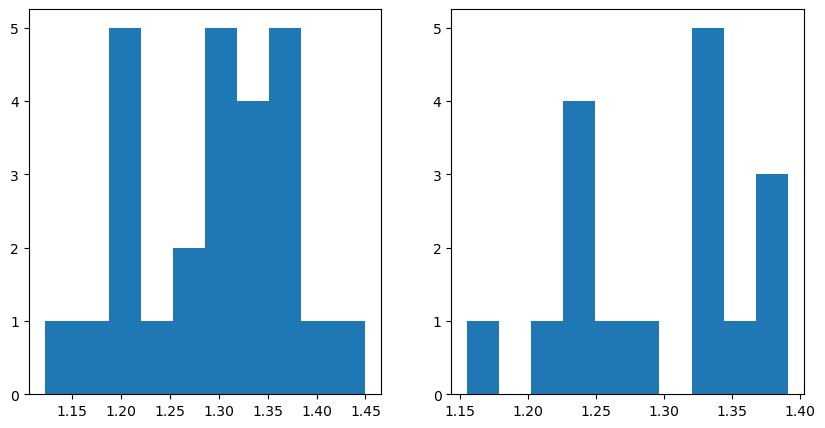

In [41]:
fig, axs = plt.subplots(1, 2, figsize = (10, 5))

_ = axs[0].hist(m1_max_scores, bins = 10)
_ = axs[1].hist(m2_max_scores, bins = 10)